In [47]:
import torch
import torchvision
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

In [48]:
TRAIN_DIR='/content/drive/MyDrive/machine learning projects/training set/monkey pox/Fold1/Fold1/Fold1/Train'
VAL_DIR='/content/drive/MyDrive/machine learning projects/training set/monkey pox/Fold1/Fold1/Fold1/Val'
TEST_DIR='/content/drive/MyDrive/machine learning projects/training set/monkey pox/Fold1/Fold1/Fold1/Test'
batch_size=128

In [49]:
transform_train= T.Compose([
    T.Resize((224, 224)),
    T.CenterCrop(224),
    T.ToTensor()
])
train_ds = ImageFolder(root=TRAIN_DIR, transform=transform_train)

In [50]:
transform_val = T.Compose([
    T.Resize((64,64)),
    T.ToTensor()
])

val_ds = ImageFolder(root=VAL_DIR, transform=transform_val)

In [51]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)

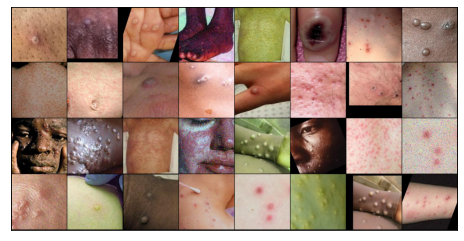

In [52]:
def show_batch(train_dl):
    for images, labels in train_dl:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:32], nrow=8).permute(1,2,0))
        break
        
show_batch(train_dl)

In [53]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")
    
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for x in self.dl:
            yield to_device(x, self.device)
            
    def __len__(self):
        return len(self.dl)
    
device = get_device()
device

device(type='cuda')

In [54]:
def accuracy(out, labels):
    _, preds = torch.max(out, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {"val_loss": loss.detach(), "val_acc": acc}
    
    def validation_epoch_end(self,outputs):
        batch_loss = [x["val_loss"] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x["val_acc"] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}
    
    def epoch_end(self, epoch, epochs, result):
        print("Epoch: [{}/{}], last_lr: {:.6f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch+1, epochs, result["lrs"][-1], result["train_loss"], result["val_loss"], result["val_acc"]))

In [55]:
class resnet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = models.resnet18(pretrained=True)
        number_of_features = self.network.fc.in_features
        self.network.fc = nn.Linear(number_of_features, 2)
        
    def forward(self, xb):
        return self.network(xb)
    
    def freeze(self):
        for param in self.network.parameters():
            param.requires_grad=False
        for param in self.network.fc.parameters():
            param.requires_grad=True
        
    def unfreeze(self):
        for param in self.network.parameters():
            param.requires_grad=True

In [56]:
model = to_device(resnet(), device)

The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.


In [57]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [58]:
@torch.no_grad()
def evaluate(model, val_dl):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_dl]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]
    
def fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, weight_decay=0,
       grad_clip=None, opt_func=torch.optim.Adam):
    history = []
    
    opt = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr, epochs=epochs,
                                               steps_per_epoch=len(train_dl))
    
    for epoch in range(epochs):
        for batch in tqdm(train_dl):
            model.train()
            train_loss = []
            lrs = []
            loss = model.training_step(batch)
            train_loss.append(loss)
            loss.backward()
            
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            
            
            opt.step()
            opt.zero_grad()
            lrs.append(get_lr(opt))
            
            sched.step()
        result = evaluate(model, val_dl)
        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["lrs"] = lrs
        model.epoch_end(epoch, epochs, result)
        history.append(result)
    return history

In [59]:
history = [evaluate(model, val_dl)]
history

[{'val_acc': 0.6421440839767456, 'val_loss': 0.6526788473129272}]

In [60]:
model.freeze()

In [61]:
epochs = 5
max_lr = 10e-4
grad_clip = 0.1
weight_decay = 10e-4
opt_func = torch.optim.Adam

In [62]:
%%time

history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                         weight_decay=weight_decay, grad_clip=grad_clip, 
                         opt_func=opt_func)

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: [1/5], last_lr: 0.000742, train_loss: 0.7300, val_loss: 0.5504, val_acc: 0.7342


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: [2/5], last_lr: 0.000950, train_loss: 0.5485, val_loss: 0.6981, val_acc: 0.7185


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: [3/5], last_lr: 0.000611, train_loss: 0.4788, val_loss: 0.8181, val_acc: 0.7068


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: [4/5], last_lr: 0.000188, train_loss: 0.4212, val_loss: 0.8142, val_acc: 0.7049


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: [5/5], last_lr: 0.000000, train_loss: 0.4364, val_loss: 0.8389, val_acc: 0.7049
CPU times: user 3 s, sys: 2.49 s, total: 5.49 s
Wall time: 40.3 s


In [63]:
model.unfreeze()

In [64]:
%%time

history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                         weight_decay=weight_decay, grad_clip=grad_clip, 
                         opt_func=opt_func)

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: [1/5], last_lr: 0.000742, train_loss: 0.0507, val_loss: 11.5616, val_acc: 0.4444


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: [2/5], last_lr: 0.000950, train_loss: 0.1615, val_loss: 6.5336, val_acc: 0.3390


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: [3/5], last_lr: 0.000611, train_loss: 0.1238, val_loss: 3.0355, val_acc: 0.4453


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: [4/5], last_lr: 0.000188, train_loss: 0.0108, val_loss: 1.8659, val_acc: 0.5488


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: [5/5], last_lr: 0.000000, train_loss: 0.0103, val_loss: 1.5231, val_acc: 0.6124
CPU times: user 9.89 s, sys: 8.37 s, total: 18.3 s
Wall time: 43.7 s


In [65]:
transform_test = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

test_ds = ImageFolder(root=TEST_DIR, transform=transform_test)

In [66]:
def img_prediction(images):
    xb = to_device(images.unsqueeze(0), device)
    out = model(xb)
    _, preds = torch.max(out, dim=1)
    prediction = preds[0].item()
    return prediction

Label: 0
Predictions: 0


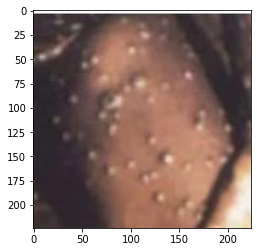

In [67]:
images, labels = test_ds[10]
print("Label:", labels)
print("Predictions:", img_prediction(images))
plt.imshow(images.permute(1,2,0))

Label: 1
Predictions: 1


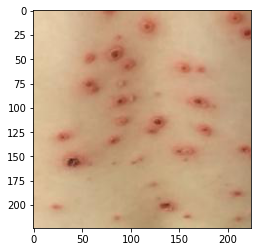

In [74]:
images, labels = test_ds[22]
print("Label:", labels)
print("Predictions:", img_prediction(images))
plt.imshow(images.permute(1,2,0))